# Movie Review Sentiment Classifier

## Importing the libraries 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, SpatialDropout1D, MaxPool1D, GlobalMaxPooling1D, Embedding, Input, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Data Preprocessing

### Getting the data

In [2]:
reviews = []
ratings = []

dataset_dir = 'cornell_nlp_dataset/scaledata'
folders = os.listdir(dataset_dir)
for folder in folders:
    fname = os.path.join(dataset_dir, str(folder)+'/'+'subj.'+str(folder))
    f = open(fname)
    data = f.read()
    lines = data.split('\n')
    reviews.extend(lines)
    reviews = reviews[:-1]
    f.close()
    fname2 = os.path.join(dataset_dir, str(folder)+'/'+'label.3class.'+str(folder))
    f2 = open(fname2)
    data2 = f2.read()
    rating = data2.split('\n')
    ratings.extend(rating)
    ratings = ratings[:-1]
    ratings = [int(rat) for rat in ratings]
    f2.close()
print(reviews[1])
print(ratings[1])

admittedly , with a title like the mangler , you're not expecting the second coming of the godfather . or even halloween , for that matter . nevertheless , regardless of how silly the name sounds and how unpromising the cast looks , it's difficult to be prepared for something this atrocious . i won't claim this is the worst movie i've ever seen--there are plenty of worthy contenders for that honor--but it's certainly among a select group , right alongside such notables as split second and dr . giggles . i haven't spent much time in laundry factories , but i'm sure there aren't many of them with the near-gothic appearance of the blue ribbon in rivers valley , maine . people are being gobbled up by " the mangler " , the gargantuan machine that presses and folds sheets . he might well have been talking about the movie itself . anyway , it's not long before we learn that the mangler isn't the only machine to run amok . apparently , a refrigerator has developed some homicidal tendencies . i

In [3]:
print('No. of reviews in this dataset: %d' %len(reviews))

No. of reviews in this dataset: 5006


### Tokenizing data

In [4]:
maxlen = 400
training_samples = 4006
val_samples = 1000
test_samples = 1000
max_words = 15000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
print('No. of unique tokens: %d' %(len(word_index)))

dataset = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(ratings)

print('Shape of dataset: ', dataset.shape)
print('Shape of labels: ', labels.shape)

indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]
labels = to_categorical(labels)

x_train = dataset[:training_samples]
y_train = labels[:training_samples]

No. of unique tokens: 46259
Shape of dataset:  (5006, 400)
Shape of labels:  (5006,)


## Model

In [11]:
model = Sequential()
model.add(Embedding(max_words, 50, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPool1D(5))
model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 50)           750000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 400, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 394, 64)           22464     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 78, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 78, 64)            24832     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [12]:
callbacks_list = [EarlyStopping(monitor='acc', patience=1), ModelCheckpoint(monitor='val_loss', filepath='trained_model.h5', save_best_only=True)]
history = model.fit(x_train, y_train, epochs=40, batch_size=64, validation_split=0.25, callbacks=callbacks_list)

Train on 3004 samples, validate on 1002 samples
Epoch 1/40
3004/3004 [==============================] - 15s 5ms/sample - loss: 1.0787 - acc: 0.4005 - val_loss: 1.0693 - val_acc: 0.4112
Epoch 2/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 1.0491 - acc: 0.4271 - val_loss: 0.9928 - val_acc: 0.4990
Epoch 3/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 0.8372 - acc: 0.5869 - val_loss: 0.8056 - val_acc: 0.5888
Epoch 4/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 0.5828 - acc: 0.7397 - val_loss: 0.8435 - val_acc: 0.6188
Epoch 5/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 0.4048 - acc: 0.8379 - val_loss: 0.9774 - val_acc: 0.6108
Epoch 6/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 0.2584 - acc: 0.9101 - val_loss: 1.2256 - val_acc: 0.6068
Epoch 7/40
3004/3004 [==============================] - 10s 3ms/sample - loss: 0.1704 - acc: 0.9358 - val_loss: 1.4346 - val_acc: 

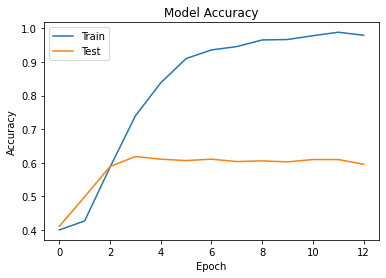

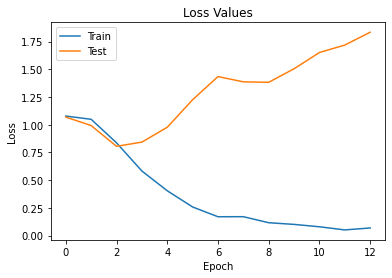

In [13]:
#Plotting Accuracy v/s Epochs
plt.figure(1)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
#Plotting Loss v/s Epochs
plt.figure(2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Values')

plt.show()